# Helper Functions

In [87]:
import statsmodels.api as sm

def performance_summary(return_data):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*12)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(12))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']
    
    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    summary_stats['Min'] = return_data.min()
    summary_stats['Max'] = return_data.max()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

def time_series_regression(portfolio, factors, FF3F = False, resid = False):
    
    ff_report = pd.DataFrame(index=portfolio.columns)
    bm_residuals = pd.DataFrame(columns=portfolio.columns)

    rhs = sm.add_constant(factors)

    for portf in portfolio.columns:
        lhs = portfolio[portf]
        res = sm.OLS(lhs, rhs, missing='drop').fit()
        ff_report.loc[portf, 'alpha_hat'] = res.params['const'] * 12
        ff_report.loc[portf, 'beta_mkt'] = res.params[1]
        if FF3F:
            ff_report.loc[portf, 'Size beta'] = res.params[2] 
            ff_report.loc[portf, 'Value beta'] = res.params[3]
            
        ff_report.loc[portf, 'info_ratio'] = np.sqrt(12) * res.params['const'] / res.resid.std()
        ff_report.loc[portf, 'treynor_ratio'] = 12 * portfolio[portf].mean() / res.params[1]
        ff_report.loc[portf, 'R-squared'] = res.rsquared
        ff_report.loc[portf, 'Tracking Error'] = (res.resid.std()*np.sqrt(12))

        if resid:
            bm_residuals[portf] = res.resid
            
            
        
    if resid:
        return bm_residuals
        
    return ff_report

def tangency_weights(returns, cov_mat = 1):
    
    if cov_mat ==1:
        cov_inv = np.linalg.inv((returns.cov()*12))
    else:
        cov = returns.cov()
        covmat_diag = np.diag(np.diag((cov)))
        covmat = cov_mat * cov + (1-cov_mat) * covmat_diag
        cov_inv = np.linalg.inv((covmat*12))  
        
    ones = np.ones(returns.columns.shape) 
    mu = returns.mean()*12
    scaling = 1/(np.transpose(ones) @ cov_inv @ mu)
    tangent_return = scaling*(cov_inv @ mu) 
    tangency_wts = pd.DataFrame(index = returns.columns, data = tangent_return, columns = ['Tangent Weights'] )
        
    return tangency_wts

# 2 The Factors
DFA believes certain stocks have higher expected excess returns. In addition to the overall market
equity premium, DFA believes that there is a premium attached to a “size” and “value” factor. Note
that these three factors are already listed as excess returns.\
Use the data found in ‘dfa analysis data.xlsx’.\
• FACTORS: Monthly excess return data for the overall equity market, $\tilde r_m$. The sheet also
contains data on two additional factors, SMB and HML, as well as the risk-free rate. You do
not need any of these columns for the homework. Just use the MKT column, which is excess
market returns. (So no need to subtract the risk-free rate.)
1. The Factors. Calculate their univariate performance statistics:\
• mean\
• volatility\
• Sharpe\
• VaR(.05)\
Report these for the following three subsamples:\
• Beginning - 1980\
• 1981 - 2001\
• 2002 - End

In [73]:
import pandas as pd
import numpy as np

factors_df = pd.read_excel(r'/Users/arohansharma/Desktop/assignments/finm-portfolio-2024/data/dfa_analysis_data.xlsx', 
                           sheet_name='factors', index_col=0)
portfolios_df = pd.read_excel(r'/Users/arohansharma/Desktop/assignments/finm-portfolio-2024/data/dfa_analysis_data.xlsx', 
                              sheet_name='portfolios (total returns)', index_col=0)
portfolios_df = portfolios_df.sub(factors_df['RF'], axis=0)
factors_df.drop(columns=['RF'], inplace=True)

print('Performance Statistics')
print('Beginning - 1980')
display(performance_summary(factors_df.loc[:pd.Timestamp('1980-12-31')]).loc[:,['Mean','Volatility','Sharpe Ratio','VaR (0.05)']])
print('1981 - 2001')
display(performance_summary(factors_df.loc[pd.Timestamp('1981-1-1'): pd.Timestamp('2001-12-31')]).loc[
    :,['Mean','Volatility','Sharpe Ratio','VaR (0.05)']])
print('2002 - End')
display(performance_summary(factors_df.loc[pd.Timestamp('2002-1-1'):]).loc[:,['Mean','Volatility','Sharpe Ratio','VaR (0.05)']])

Performance Statistics
Beginning - 1980


,Mean,Volatility,Sharpe Ratio,VaR (0.05)
Mkt-RF,0.081138,0.205050,0.395696,-0.083985
SMB,0.033985,0.114568,0.296638,-0.043400
HML,0.049479,0.133825,0.369727,-0.042910


1981 - 2001


,Mean,Volatility,Sharpe Ratio,VaR (0.05)
Mkt-RF,0.077257,0.157396,0.490847,-0.064545
SMB,-0.000862,0.118346,-0.007283,-0.046515
HML,0.063776,0.111183,0.573612,-0.041790


2002 - End


,Mean,Volatility,Sharpe Ratio,VaR (0.05)
Mkt-RF,0.089488,0.154644,0.578674,-0.078735
SMB,0.011007,0.088944,0.123757,-0.039070
HML,0.000538,0.107348,0.005014,-0.041245


2. Based on the factor statistics above, answer the following.\
(a) Does each factor have a premium (positive expected excess return) in each subsample?\
No, SMB from 1981 to 2001 does not have a premium. Apart from this, all factors have a premium across all periods.\
(b) Does the premium to the size factor get smaller after 1980?\
Yes
(c) Does the premium to the value factor get smaller during the 1990’s?
Value factor increases till 2001 but goes down afterwards.
(d) How have the factors performed since the time of the case, (2002-present)?\
All factors have had a premium attached to them.

3. The factors are constructed in such a way as to reduce correlation between them.\
Report the correlation matrix across the three factors. Does the construction method succeed\
in keeping correlations small? Does it achieve this in each subsample?

In [74]:
print('Correlation')
print('Full History')
display(factors_df.corr())
print('Beginning - 1980')
display(factors_df.loc[:pd.Timestamp('1980-12-31')].corr())
print('1981 - 2001')
display(factors_df.loc[pd.Timestamp('1981-1-1'): pd.Timestamp('2001-12-31')].corr())
print('2002 - End')
display(factors_df.loc[pd.Timestamp('2002-1-1'):].corr())

Correlation
Full History


,Mkt-RF,SMB,HML
Mkt-RF,1.00000,0.314710,0.226890
SMB,0.31471,1.000000,0.120774
HML,0.22689,0.120774,1.000000


Beginning - 1980


,Mkt-RF,SMB,HML
Mkt-RF,1.000000,0.366298,0.437848
SMB,0.366298,1.000000,0.309133
HML,0.437848,0.309133,1.000000


1981 - 2001


,Mkt-RF,SMB,HML
Mkt-RF,1.000000,0.164264,-0.527221
SMB,0.164264,1.000000,-0.453656
HML,-0.527221,-0.453656,1.000000


2002 - End


,Mkt-RF,SMB,HML
Mkt-RF,1.000000,0.306309,0.127782
SMB,0.306309,1.000000,0.128111
HML,0.127782,0.128111,1.000000


Correlation is small through all periods

4. Plot the cumulative returns of the three factors. Create plots for the 1981-2001 subsample as
well as the 2002-Present subsample.

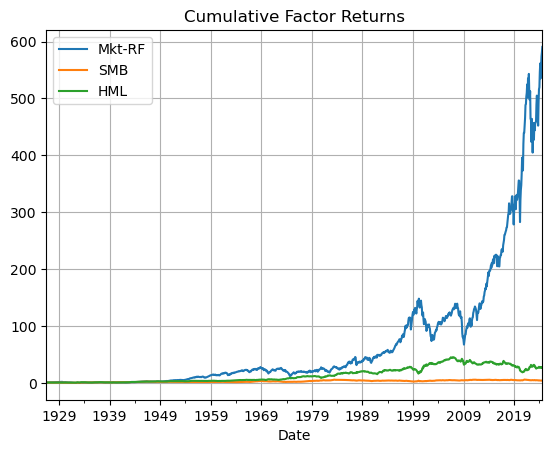

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline

figure = ((factors_df + 1).cumprod()).plot()
plt.grid()
plt.title('Cumulative Factor Returns')
plt.show()

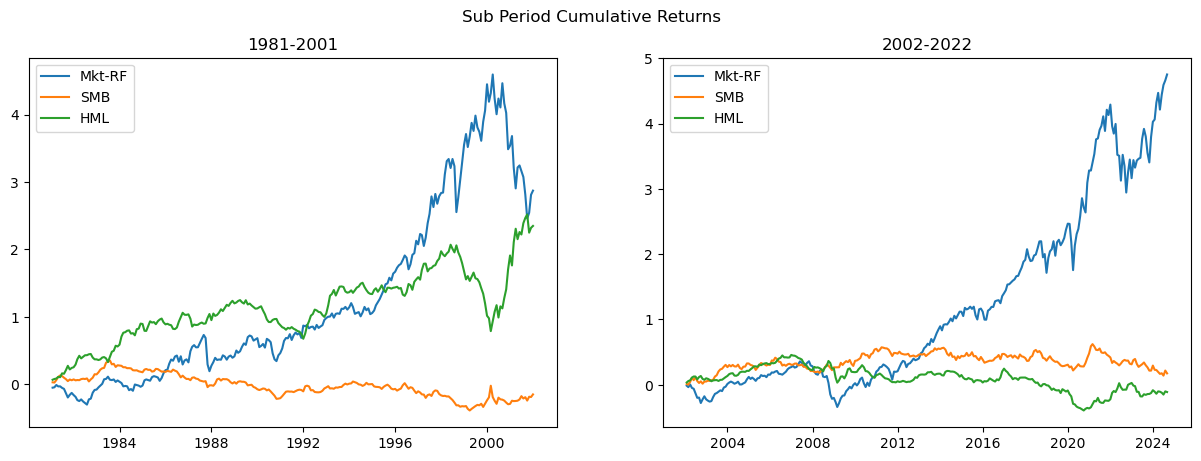

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Sub Period Cumulative Returns')
ax1.plot(((factors_df.loc[pd.Timestamp('1981-1-1'): pd.Timestamp('2001-12-31')] + 1).cumprod() - 1))
ax2.plot(((factors_df.loc[pd.Timestamp('2002-1-1'):] + 1).cumprod() - 1))

fig.set_figwidth(15)
ax1.legend(factors_df.loc[pd.Timestamp('1981-1-1'): pd.Timestamp('2001-12-31')].columns)
ax2.legend(factors_df.loc[pd.Timestamp('2002-1-1'):].columns)

ax1.title.set_text('1981-2001')
ax2.title.set_text('2002-2022')

5. Does it appear that all three factors were valuable in 1981-2001? And post-2001? Would you advise DFA to continue emphasizing all three factors? 

Market was valuable in both sub-periods. HML was valuable from 1981 to 2001. SMB was not valuable through any of the above two periods. Though all 3 factors still possess some relevant characterisitics, it appears that Factor rotation might be a better strategy in hindsight. The size factor seems our of favor for a long time now and the returns seem correlated to the Market Factor. DFA should also try to explore other factors such as volatility, liquidity, momentum etc. to generate alpha while sticking to their belief of capital markets being efficient.

# 3 CAPM
DFA believes that premia in stocks and stock portfolios is related to the three factors.\
Let’s test 25 equity portfolios that span a wide range of size and value measures.\
• PORTFOLIOS: Monthly total return data on 25 equity portfolios sorted by their size-value
characteristics. Denote these as ri, for n = 1, . . . , 25.\
• Note that while the factors were given as excess returns, the portfolios are total returns.\
• For this entire problem, focus on the 1981-Present subsample.\
1. Summary Statistics. For each portfolio,\
• Use the Risk-Free rate column in the factors tab to convert these total returns to excess
returns.\
• Calculate the (annualized) univariate statistics from 1.1.\
• Can the difference in mean excess returns of the portfolios be explained by differences in
their volatilities? Or by their VaR(.05) statistics?

In [60]:
port_summary = performance_summary(portfolios_df.loc['1981-01-01':])
port_summary.loc[:,['Mean','Volatility','Sharpe Ratio','VaR (0.05)']].sort_values(by='Volatility')

,Mean,Volatility,Sharpe Ratio,VaR (0.05)
ME5 BM3,0.082494,0.153112,0.538784,-0.070380
ME5 BM2,0.085241,0.154047,0.553343,-0.065048
BIG LoBM,0.093934,0.164046,0.572606,-0.075476
ME5 BM4,0.070224,0.171588,0.409259,-0.075757
ME3 BM3,0.092339,0.173044,0.533618,-0.073470
ME4 BM3,0.092687,0.175281,0.528792,-0.075607
ME4 BM4,0.101693,0.176070,0.577571,-0.069504
ME4 BM2,0.095974,0.177871,0.539572,-0.072905
ME3 BM4,0.108758,0.180873,0.601296,-0.071814
ME2 BM4,0.108835,0.182098,0.597670,-0.076138


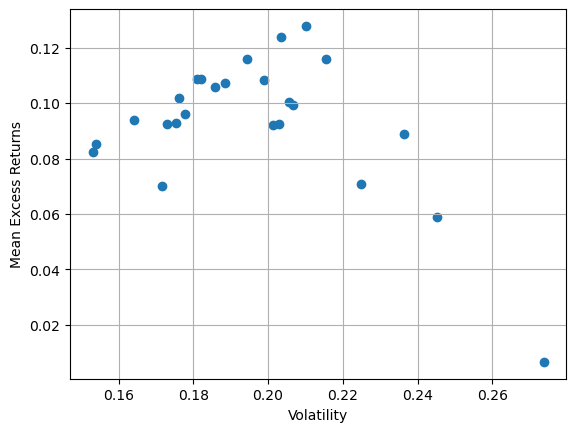

In [63]:
plt.scatter(port_summary.loc[:,['Volatility']],port_summary.loc[:,['Mean']])
plt.grid()
plt.xlabel("Volatility")
plt.ylabel("Mean Excess Returns")
plt.show()

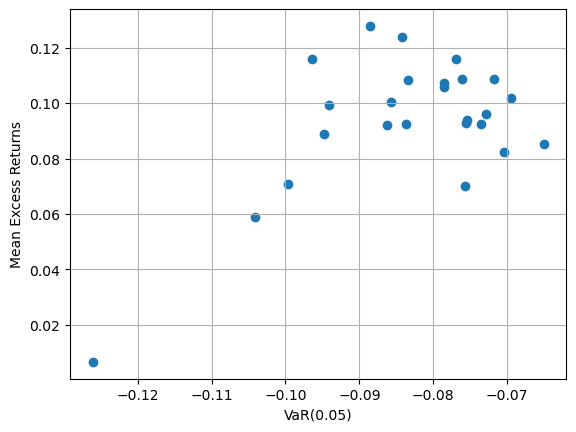

In [67]:
plt.scatter(port_summary.loc[:,['VaR (0.05)']],port_summary.loc[:,['Mean']])
plt.grid()
plt.xlabel("VaR(0.05)")
plt.ylabel("Mean Excess Returns")
plt.show()

2. CAPM
The Capital Asset Pricing Model (CAPM) asserts that an asset (or portfolio’s) expected excess
return is completely a function of its beta to the equity market index (SPY, or in this case,
MKT.)\
Specifically, it asserts that, for any excess return, $\tilde r_i$, its mean is proportional to the mean excess
return of the market, $\tilde r_m$, where the proporitonality is the regression beta of $\tilde r_i$ on $\tilde r_m$.\
$E[\tilde r^i_t] = \beta^{i,m} E[\tilde r^m_t}]$ (CAPM)\
Let’s examine whether that seems plausible.\
(a) For each of the n = 25 test portfolios, run the CAPM time-series regression:\
$\tilde r^i_t= \alpha i + \beta^{i,m} \tilde r^m_t + \epsilon^i_t$\
So you are running 25 separate regressions, each using the T-sized sample of time-series
data.\
Report the betas and alphas for each test asset.\
(b) Report the mean-absolute-error of the CAPM:\
$MAE ={1\over n}\sum_{i=1}^n |\alpha i|$\
If the CAPM were true, what would we expect of the MAE?\
(c) Report the estimated βi,m, Treynor Ratio, αi, and Information Ratio for each of the n
regressions.\
(d) If (CAPM) were true, what would be true of the Treynor Ratios, alphas, and Information
Ratios?

In [79]:
ts_CAPM = time_series_regression(portfolios_df.loc['1981':], factors_df.loc['1981':,'Mkt-RF'])
ts_CAPM

,alpha_hat,beta_mkt,info_ratio,treynor_ratio,R-squared,Tracking Error
SMALL LoBM,-0.106730,1.356365,-0.613409,0.004918,0.596078,0.173994
ME1 BM2,-0.008774,1.165744,-0.057999,0.076080,0.590508,0.151278
ME1 BM3,0.004620,1.045218,0.039081,0.088026,0.655026,0.118204
ME1 BM4,0.034696,0.972450,0.285425,0.119285,0.608481,0.121558
SMALL HiBM,0.044652,0.994979,0.315148,0.128483,0.544955,0.141685
ME2 BM1,-0.053049,1.338627,-0.411917,0.043976,0.724033,0.128787
ME2 BM2,0.005631,1.134902,0.053775,0.088568,0.740451,0.104708
ME2 BM3,0.019949,1.028607,0.212415,0.103000,0.744454,0.093913
ME2 BM4,0.027344,0.974696,0.272232,0.111660,0.695744,0.100444
ME2 BM5,0.022822,1.114415,0.178588,0.104085,0.648719,0.127793


In [81]:
# Mean-absolute-error of the CAPM
MAE = pd.DataFrame([(((ts_CAPM['alpha_hat']).abs().mean()))], columns = ['MAE (%)'], index = ['CAPM'])
MAE

,MAE (%)
CAPM,0.022428


If CAPM were true, the Mean Absolute Error (MAE) should be 0. CAPM assumes that the portfolio's return is fully explained by its exposure to market risk (beta) and the market risk premium. If this assumption is true, the return of the portfolio would align perfectly with what the model predicts, leaving no errors (residuals). But evidently, MAE is not explicitly 0, which means there is some residuals such that not all of the portfolio's return can be explained by the market risk premium.\

If CAPM were true, we would observe **same** Treynor ratios for all 25 portfolios as the portfolio returns should completely be a function of market returns (SPY). However, as we observe, most portfolios have varying Treynor ratios, indicating towards and high alpha and/or low regression beta. 

The alphas should similarly have been lower (ideally 0) for all portfolios and we should have also seen low absolute magnitude of the residuals, resulting in lower (ideally 0) information ratios. But we observe, that the alphas are still higher than expected and the Information ratios are higher than expected indicating towards presence of other regressors that should be included in the model.

3. Cross-sectional Estimation
Let’s test (CAPM) directly. We already have what we need:\
• The dependent variable, (y): mean excess returns from each of the n = 25 portfolios.\
• The regressor, (x): the market beta from each of the n = 25 time-series regressions.\
Then we can estimate the following equation:
$\mathbb E[\tilde r^i] = \eta + \beta^{i,m} + \nu$\
• Note that we use sample means as estimates of $\mathbb E[\tilde r^i]$.\
• This is a weird regression! The regressors are the betas from the time-series regressions we
already ran!\
• This is a single regression, where we are combining evidence across all n = 25 series. Thus,
it is a cross-sectional regression!\
• The notation is trying to emphasize that the intercept is different than the time-series α
and that the regressor coefficient is different than the time-series betas.\
(a) Report the R-squared of this regression.\
(b) Report the intercept, η.\
(c) Report the regression coefficient, λm.\
What would these three statistics be if (CAPM) were true?

In [80]:
portfolio = portfolios_df.loc['1981':].mean().to_frame('Mean Portfolio excess returns')
time_series_regression(portfolio, ts_CAPM['beta_mkt'])

,alpha_hat,beta_mkt,info_ratio,treynor_ratio,R-squared,Tracking Error
Mean Portfolio excess returns,0.208623,-0.009015,35.404667,-10.4114,0.300557,0.005893


we would expect a very low alpha, a high beta and a very high R-Squared from the above regression.

4. Broadly speaking, do these results support DFA’s belief in size and value portfolios containingpremia unrelated to the CAPM?\

Low R-Squared and Betas and higher alpha from the cross-sectional regression in the previous question, indicat the presence of other risk factors in the market that can explain excess returns of equity portfolios. Also, as shown by the Fama-French paper, size and value have posted premiums in the past and thus can be used to explain mean excess returns in better capacity than CAPM alone. These results do support DFA's belief in size and value portfolios containing premia unrelated to CAPM.

Using Size and Value as additional factors in the regression for the 25 portfolios, we see a higher R-Squared in the regression, further strengthening DFA's belief in existence of premia in Value and Size Factors

# 4) Extensions

portfolios_df### 4.1) Re-do the analysis of 3.3 and 3.3, but instead of using the market return as the factor, use a new factor: the in-sample tangency portfolio of the n = 25 portfolios.

In [83]:
portfolios_df

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,ME3 BM1,ME3 BM2,ME3 BM3,ME3 BM4,ME3 BM5,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Date,,,,,,,,,,,,,,,,,,,,,,,,,
1926-07-31,0.056048,-0.019206,0.002675,-0.016780,0.018334,0.009877,0.021992,0.002726,-0.028249,-0.005544,0.016916,0.022136,-0.006547,0.035088,-0.014829,0.013693,0.013078,0.010778,0.000527,0.022478,0.032339,0.058702,0.018066,0.028911,0.003423
1926-08-31,-0.022706,-0.082782,0.011296,0.012106,0.081468,0.021118,-0.014349,0.037584,0.002538,0.059175,-0.011890,0.021386,0.017412,0.040480,0.078669,0.010836,0.036230,0.017521,0.019206,0.050922,0.007624,0.039403,0.017631,0.052349,0.075076
1926-09-30,-0.050591,-0.028454,-0.045717,-0.035029,0.006349,-0.028840,-0.014918,0.008529,-0.037780,-0.011701,-0.006198,-0.000610,-0.021628,0.024646,-0.038515,0.008623,-0.007550,-0.019936,0.012346,0.006430,-0.015206,0.034238,-0.001350,-0.009787,-0.026584
1926-10-31,-0.096929,-0.038719,-0.038148,0.031213,-0.028676,-0.031269,-0.035863,-0.053945,-0.083391,-0.016413,-0.054361,-0.028783,0.001093,-0.025019,-0.034573,-0.036561,-0.029759,-0.024270,-0.034251,-0.056725,-0.030613,-0.033271,-0.025637,-0.049919,-0.061329
1926-11-30,0.052788,0.038777,0.021523,-0.047594,0.002262,0.027933,-0.026790,0.026978,0.048446,0.024192,0.016007,0.042367,0.001671,0.046330,0.034233,0.031348,0.020787,0.034235,0.046220,0.015113,0.039846,0.022226,0.012104,0.033519,0.022536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30,-0.130128,-0.076561,-0.079804,-0.079124,-0.080168,-0.072984,-0.087440,-0.068110,-0.060808,-0.073370,-0.067559,-0.067537,-0.064552,-0.068495,-0.083252,-0.061889,-0.068962,-0.064723,-0.073261,-0.062037,-0.044696,0.007208,-0.049422,-0.054638,-0.059445
2024-05-31,0.067929,0.028121,0.044908,0.031166,0.043491,0.041575,0.027868,0.050656,0.044027,0.046318,0.042077,0.047270,0.036694,0.049952,0.036103,0.021254,0.017390,0.019487,0.048526,0.031667,0.055412,0.037588,0.026122,0.036084,0.038259
2024-06-30,-0.047089,-0.027302,-0.060055,-0.020509,-0.029688,-0.023300,-0.024891,-0.024715,-0.019464,-0.032911,0.023802,-0.013069,-0.023490,-0.029968,-0.027565,-0.010171,-0.021718,-0.026953,-0.020711,-0.031647,0.057072,0.006973,-0.000874,-0.020792,0.002003


In [90]:
w_t = tangency_weights(portfolios_df.loc[pd.Timestamp('1981-1-1'):])
TangencyPort_df = pd.DataFrame(w_t,columns= ["Tangent Weights"])
TangencyRets = (portfolios_df @ TangencyPort_df).rename(columns={'Tangency Portfolio Weight':'Tangency Returns'})
tangency_ts = time_series_regression(portfolios_df.loc[pd.Timestamp('1981-1-1'):], TangencyRets.loc[pd.Timestamp('1981-1-1'):],False)
tangency_ts

,alpha_hat,beta_mkt,info_ratio,treynor_ratio,R-squared,Tracking Error
SMALL LoBM,1.014813e-15,0.017416,3.707125e-15,0.383026,0.000174,0.273747
ME1 BM2,7.025630e-16,0.231549,3.035227e-15,0.383026,0.041297,0.231470
ME1 BM3,8.534840e-16,0.240209,4.377221e-15,0.383026,0.061325,0.194983
ME1 BM4,1.269818e-15,0.302847,6.907643e-15,0.383026,0.104610,0.183828
SMALL HiBM,8.404735e-16,0.333758,4.238534e-15,0.383026,0.108695,0.198293
ME2 BM1,5.984796e-16,0.153692,2.462139e-15,0.383026,0.016918,0.243073
ME2 BM2,7.572068e-16,0.262425,3.820699e-15,0.383026,0.070178,0.198185
ME2 BM3,5.165139e-16,0.276604,2.923266e-15,0.383026,0.095427,0.176691
ME2 BM4,5.874207e-16,0.284144,3.409461e-15,0.383026,0.104810,0.172291
ME2 BM5,1.492296e-15,0.302836,7.235100e-15,0.383026,0.084917,0.206258


In [91]:
portfolio = portfolios_df.loc[pd.Timestamp('1981-1-1'):].mean().to_frame('Mean Portfolio excess returns')
time_series_regression(portfolio, tangency_ts.loc[:,['beta_mkt']], False)

,alpha_hat,beta_mkt,info_ratio,treynor_ratio,R-squared,Tracking Error
Mean Portfolio excess returns,5.945900e-16,0.031919,6.859416,2.940675,1.0,8.668229e-17


The MV model can explain perfectly explain the variation excess return. The R^2 is 1. The alpha is 0. All the varation in the in-sample excess return can be explain by the variation of the in-sample tangency portfolio.

### 4.2) Re-do the analysis of 3.3 and 3.4, but instead of using the market return as the factor, use all three factors, (MKT, SMB, and HML). Note again that all three are already given as excess returns, so there is no need to use the risk-free rate data.
### Thus, instead of testing (CAPM), you will be testing the Fama-French 3-Factor Model.

In [92]:
ts_FF3F = time_series_regression(portfolios_df.loc[pd.Timestamp('1981-1-1'):], factors_df.loc[pd.Timestamp('1981-1-1'):],True)
ts_FF3F

,alpha_hat,beta_mkt,Size beta,Value beta,info_ratio,treynor_ratio,R-squared,Tracking Error
SMALL LoBM,-0.085811,1.111846,1.392517,-0.253788,-0.937530,0.006000,0.888226,0.091529
ME1 BM2,0.001435,0.965456,1.317675,-0.014432,0.020344,0.091863,0.910924,0.070556
ME1 BM3,0.000595,0.923142,1.065113,0.277445,0.011988,0.099666,0.939265,0.049597
ME1 BM4,0.022184,0.877818,1.065753,0.477399,0.467283,0.132144,0.940281,0.047474
SMALL HiBM,0.023053,0.929787,1.066006,0.691417,0.312014,0.137492,0.876254,0.073886
ME2 BM1,-0.032422,1.141897,1.023281,-0.310250,-0.539477,0.051553,0.939904,0.060099
ME2 BM2,0.007150,1.013778,0.915858,0.121287,0.141210,0.099149,0.939304,0.050635
ME2 BM3,0.008658,0.973977,0.719244,0.389224,0.165561,0.108777,0.920763,0.052295
ME2 BM4,0.008373,0.941288,0.748332,0.575080,0.186100,0.115623,0.938957,0.044991
ME2 BM5,-0.005771,1.089194,0.929779,0.832768,-0.124297,0.106495,0.953637,0.046426


In [94]:
portfolio = portfolios_df.loc[pd.Timestamp('1981-1-1'):].mean().to_frame('Mean Portfolio excess returns')
time_series_regression(portfolio, ts_FF3F.loc[:,['beta_mkt','Size beta','Value beta']], True)

,alpha_hat,beta_mkt,Size beta,Value beta,info_ratio,treynor_ratio,R-squared,Tracking Error
Mean Portfolio excess returns,0.186491,-0.008349,-0.000156,0.002927,36.112277,-11.24266,0.462776,0.005164


### 4.3.a) Report the mean-absolute-error of the CAPM:

In [95]:
pd.DataFrame([(((ts_CAPM['alpha_hat']).abs().mean()))], columns = ['MAE (%)'], index = ['CAPM'])

,MAE (%)
CAPM,0.022428


### 4.3.b) Under classic statistical assumptions, we can test the null hypothesis that the CAPM works by calculating,

In [97]:
resid = time_series_regression(portfolios_df.loc[pd.Timestamp('1981-1-1'):], factors_df.loc[pd.Timestamp('1981-1-1'):,'Mkt-RF'], 
                               False, True)

In [100]:
import scipy.stats as stats

T = portfolios_df.loc[pd.Timestamp('1981-1-1'):].shape[0]
SR = factors_df.loc[pd.Timestamp('1981-1-1'):]['Mkt-RF'].mean() *12/ factors_df.loc[pd.Timestamp('1981-1-1'):]['Mkt-RF'].std()*np.sqrt(12)
Sigma = resid.cov()
Sigma_inv = pd.DataFrame(np.linalg.inv(Sigma), index=Sigma.index, columns=Sigma.columns)
alpha = ts_CAPM['alpha_hat']

H = T * (1 + SR**2)**(-1) * (alpha @ Sigma_inv @ alpha)

print('H = {:.2f}'.format(H))
pvalue = 1 - stats.chi2.cdf(H, df=25)
print('p-value = {:.4f}'.format(pvalue))

H = 472.07
p-value = 0.0000


### 4.3.c) Which is a stricter test: checking whether any of the n values of $\alpha^{i}$ have a statistically significant t-test or checking whether H calculated above is significant?

- By definition, a joint test is stricter than testing the conditions individually.

- In our case, we can see that most of the alphas (20 alphas) are not significant (has p-value > 0.05) while 5 alphas are signficant (has p-value < 0.05) as judged by their individual -stats, yet all of them are jointly significant as judged by this joint test.

### 4.3.d) Conceptually, how does the test-statistic H relate to checking whether $\tilde{r}^{m}$ spans the tangency portfolio?
- We have demonstrated that an LFM is exactly the same as asserting that a set of factors spans the MV frontier, (and thus spans the tangency portfolio.) 
- Thus, this test can be interpreted as checking whether investing in the alphas gets beyond the tangency portfolio. The test stat is basically comparing the square SR of the alphas to the square SR of the factors.